# Problem Demonstration

In [211]:
#test change
import random
import torch
import numpy as np
from tqdm.auto import trange
from tqdm import tqdm

from scipy.optimize import minimize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

## Define Some Helper Function

In [212]:
def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sample(num_points, dims, seed=42):
    """generate random points in the domain"""
    set_seeds(seed)
    return torch.rand(num_points, dims)

seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

In [213]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)
n_init = 5
n_campaigns = 5
budget = 30-n_init

ensemble_y = np.zeros((n_campaigns, n_init+budget))
ensemble_X = np.zeros((n_campaigns, 6, n_init+budget))
ensemble_params = np.zeros((n_campaigns, 8, budget))
ensemble_acqf = np.zeros((n_campaigns, budget))

# generate starting data values
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True)
X_ = random_sample(n_init, 6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

# iterate through each campaign (random seed)
for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[i]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()

    # iterate through each trial up to budget - n_initial
    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X = X,
            train_Y = y,
            input_transform=Normalize(d=X.shape[-1]), # normalize X values
            outcome_transform=Standardize(m=y.shape[-1]) # standardize y values
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        # store the fitted model hyperparameters
        ensemble_params[i,:,j] = np.array([
            *gp.covar_module.base_kernel.lengthscale[0].detach().numpy(),
            gp.covar_module.outputscale.item(),
            gp.likelihood.noise.item()
        ])

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])

        X_new, acq_value = optimize_acqf(
            acq_function= UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            q=1, # how many new points to generate
            num_restarts = 20, # how many times to restart the optimizer
            raw_samples = 200 # how many initial points to sample acqf space from
        )

        ensemble_acqf[i,j] = acq_value.item()

        X = torch.cat([X, X_new])
        y = torch.cat([y, HART(X=X_new)[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")

    ensemble_y[i,:] = y.flatten()
    ensemble_X[i,:,:] = X.T

  0%|          | 0/5 [00:00<?, ?it/s]

Campaign 1 | Best Value 3.32: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]t/s]
Campaign 2 | Best Value 3.321: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]  5.71s/it]
Campaign 3 | Best Value 3.305: 100%|██████████| 25/25 [00:04<00:00,  5.09it/s]  5.16s/it]
Campaign 4 | Best Value 3.305: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]  5.05s/it]
Campaign 5 | Best Value 3.316: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]  5.30s/it]
Processing Trial 25 of Campaign 5: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


### Plot of Optimization Performance Variation Across Campaigns

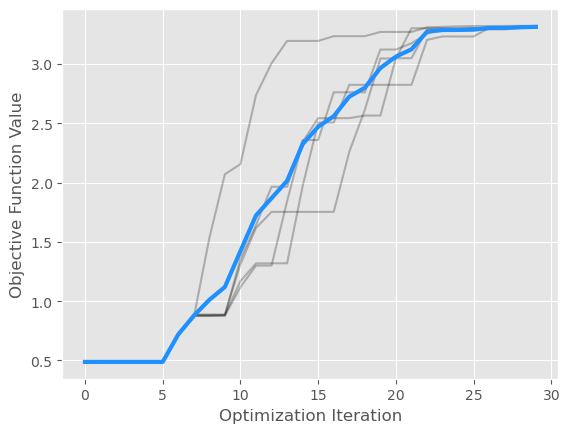

In [220]:
best_to_trial = np.maximum.accumulate(ensemble_y, axis=1)
best_to_trial_mean = np.mean(best_to_trial, axis=0)
plt.plot(best_to_trial.T, color='black', alpha=0.25, label='trials')
plt.plot(best_to_trial_mean, lw=3, color='dodgerblue', label='mean')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.show()

### Plot of Hyperparameter Variation Across Campaigns

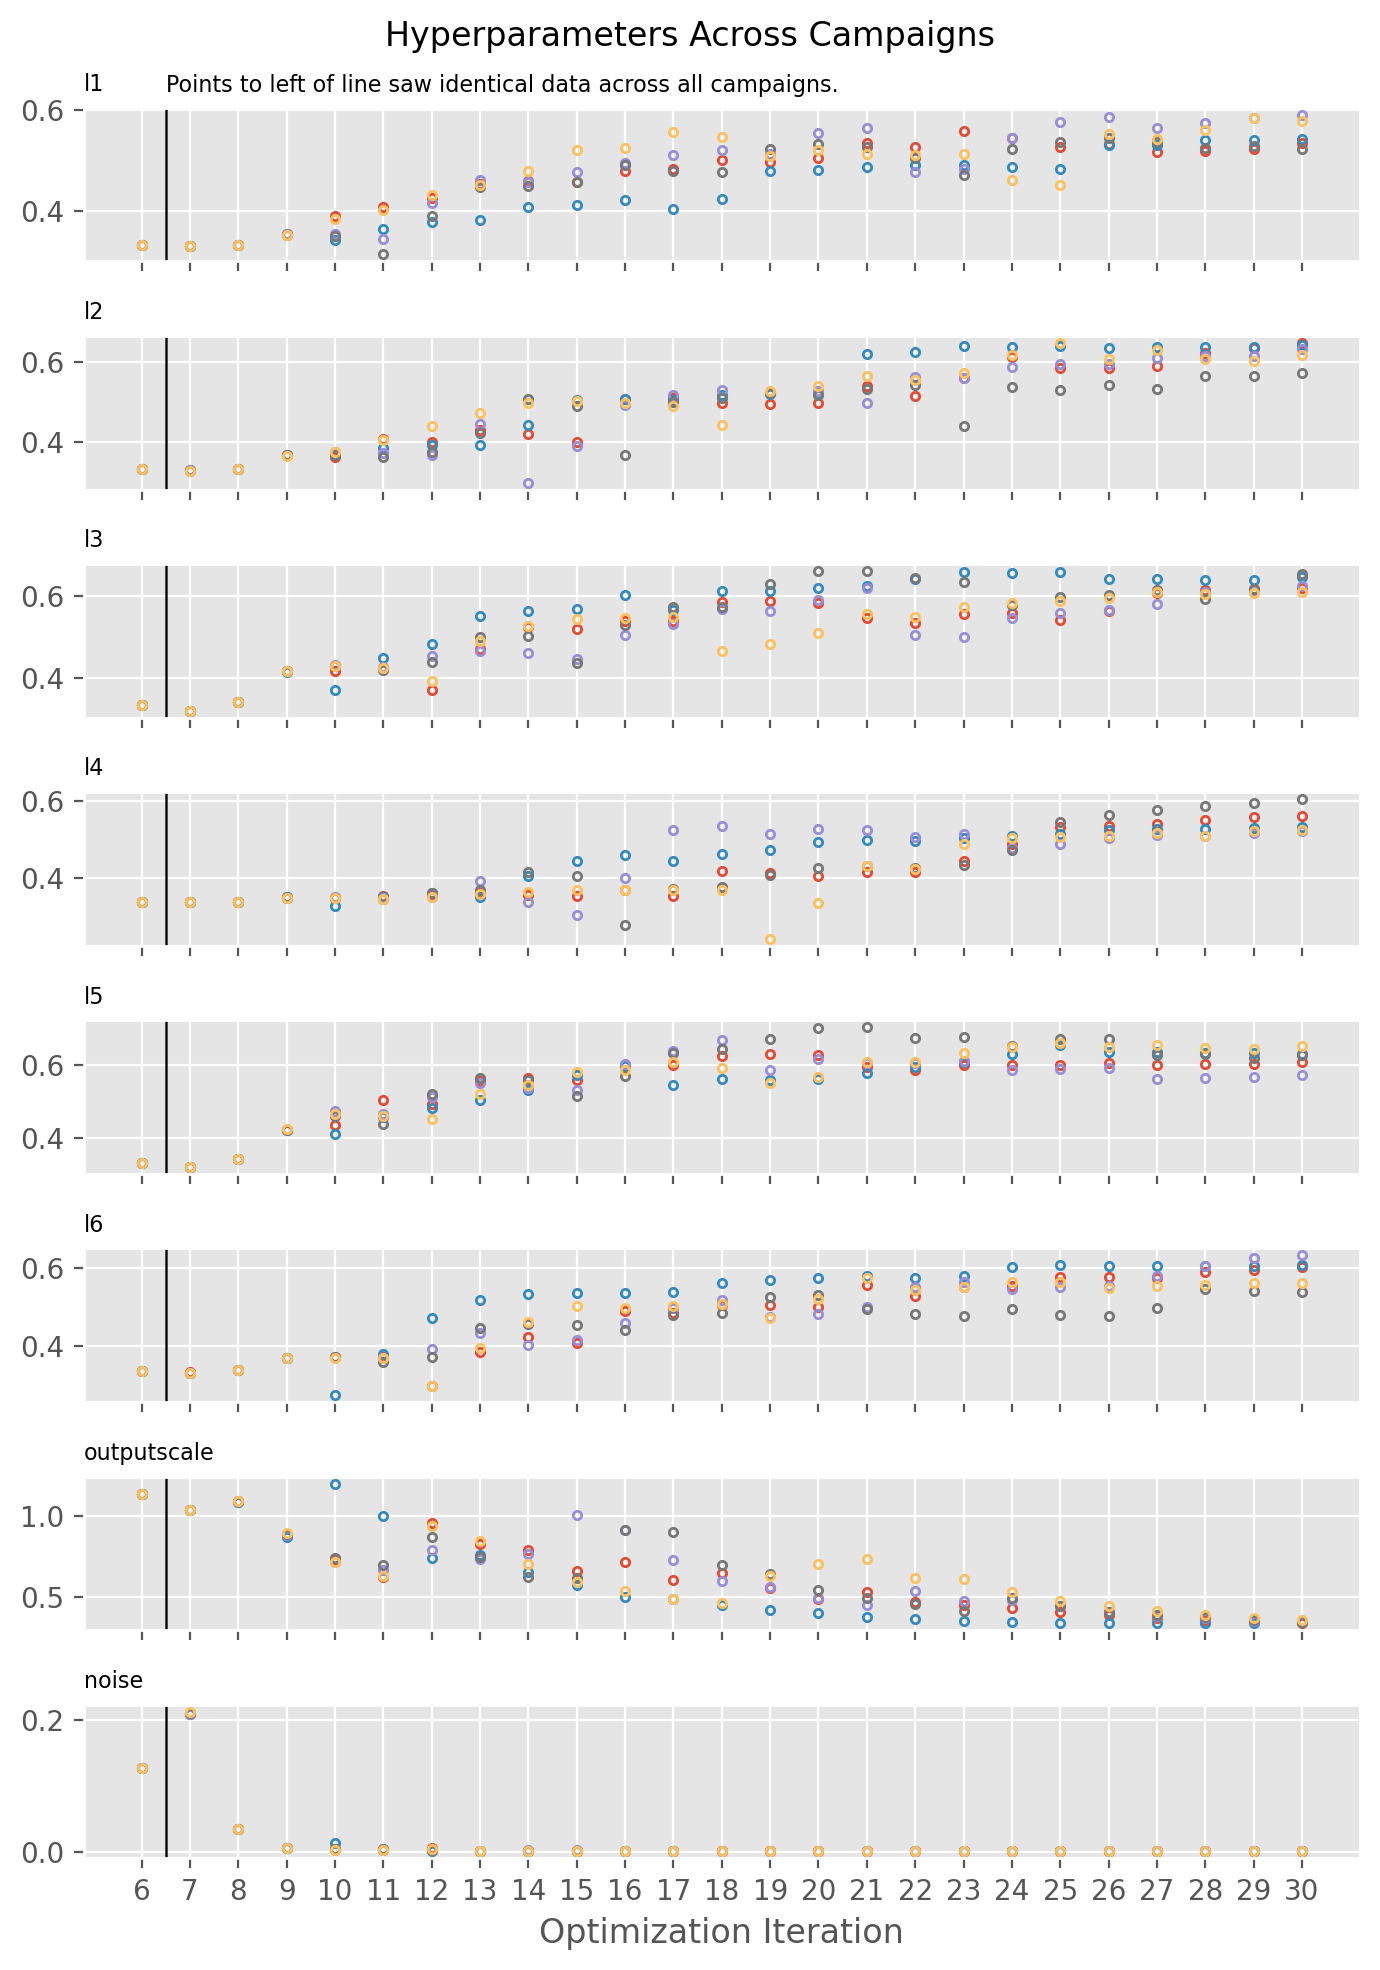

In [215]:
# let's plot the hyperparameters of the model
fig, ax = plt.subplots(nrows=8, 
                       layout='tight',
                       sharex=True,
                       figsize=(7,10),
                       dpi=200)

names = ['l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'outputscale', 'noise']
for i in range(n_campaigns):
    for j in range(8):
        ax[j].plot(ensemble_params[i,j,:], marker='.', ls="None", label=f"Campaign {i+1}", mfc="None")
        ax[j].set_title(names[j], fontsize=8, loc='left')
        ax[j].set_xticks(np.arange(0, budget, 1))
        ax[j].set_xticklabels(np.arange(0, budget, 1)+n_init+1)
        ax[j].axvline(0.5, color='black', lw=0.5)
ax[-1].set_xlabel("Optimization Iteration")

# put text to right of axvline on first plot with text
min, max = ax[0].get_ylim()
ax[0].text(0.5, max+0.03, "Points to left of line saw identical data across all campaigns.", fontsize=8)

# super title for ax[0]
fig.suptitle("Hyperparameters Across Campaigns", fontsize=12)

plt.show()

### Plot of ACQFunction Variation Across Campaigns

Text(0, 0.5, 'Acquisition Function Value')

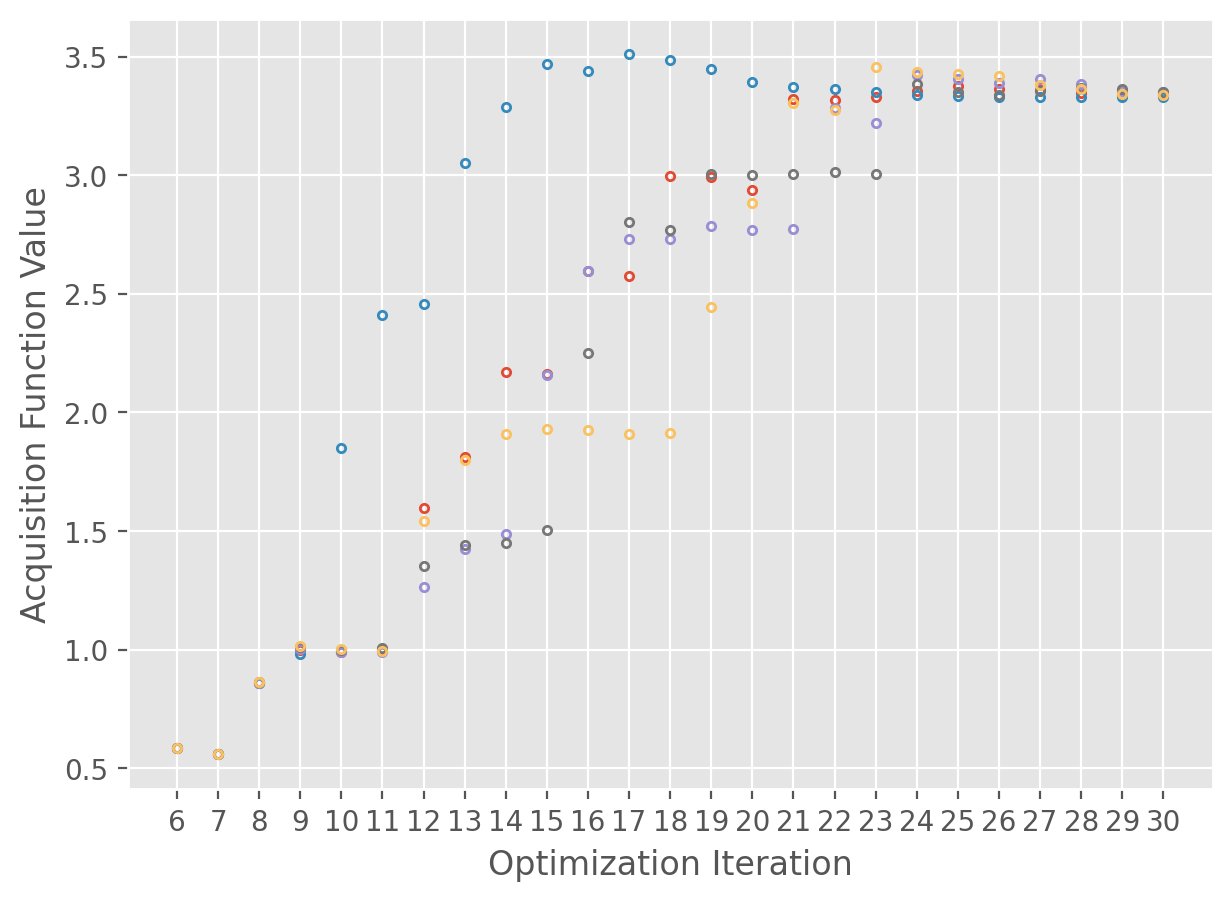

In [216]:
fig, ax = plt.subplots(figsize=(7,5), dpi=200)
for i in range(n_campaigns):
    plt.plot(ensemble_acqf[i,:], label=f"Campaign {i+1}", marker='.', ls="None", mfc="None")
plt.xticks(np.arange(0, budget, 1), np.arange(0, budget, 1)+n_init+1)
plt.xlabel("Optimization Iteration")
plt.ylabel("Acquisition Function Value")



### Plot the New X Values Proposed Across Campaigns

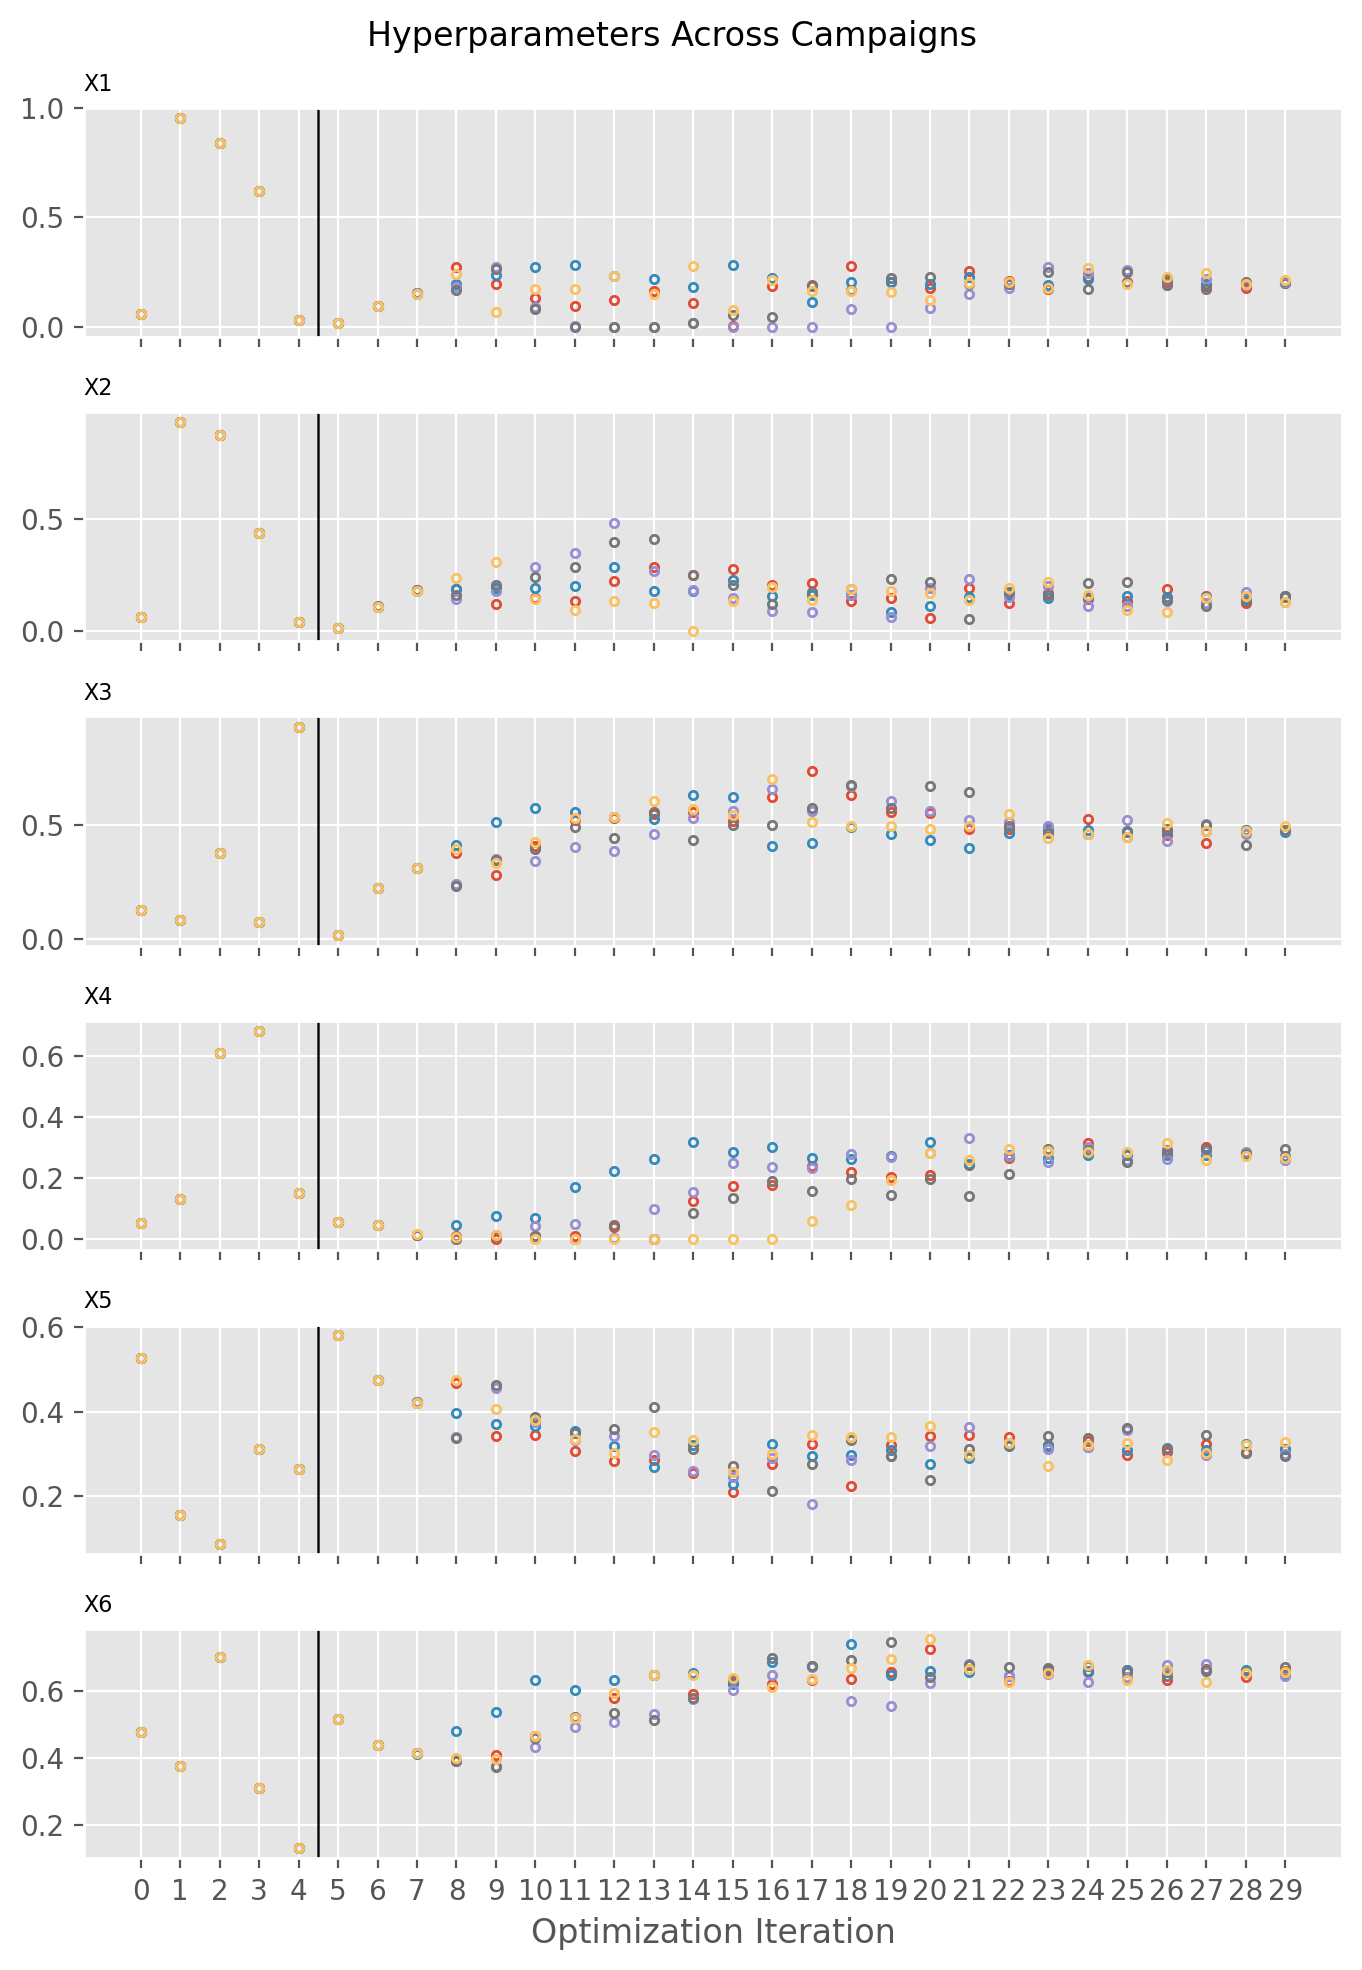

In [217]:
# plot the x values
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(7,10), dpi=200, layout='tight', sharex=True)
for i in range(n_campaigns):
    for j in range(6):
        ax[j].plot(ensemble_X[i,j,:], label=f"Campaign {i+1}", marker='.', ls="None", mfc="None")
        ax[j].set_title(f"X{j+1}", fontsize=8, loc='left')
        ax[j].set_xticks(np.arange(0, budget+n_init, 1))
        ax[j].axvline(n_init-0.5, color='black', lw=0.5)

ax[-1].set_xlabel("Optimization Iteration")
fig.suptitle("Hyperparameters Across Campaigns", fontsize=12)
plt.show()

## An Example Random Restarts Optimizer
Training on three data points.

In [218]:
# call optimizer with num restarts

# use sobol to generate that many points

# for each sobol point, run the optimizer

# save the best value
from scipy.stats.qmc import Sobol

# enforce that num points is a multiple of 2
num_points = nearest_power_of_two(20)
points = Sobol(d=6, optimization="random-cd").random(num_points)
for point in points:
    print(point)
    break

[0.02043317 0.59589114 0.92507649 0.89827897 0.48571361 0.42386526]


In [219]:
# define a UCB function for the scipy optimizer
def UCB(X, gp, beta=2):
    X = torch.tensor(X)
    mean = gp.posterior(X).mean
    std = gp.posterior(X).stddev
    UCB_val = mean + beta*std
    return -UCB_val.detach().numpy().item()

# build and train a simple model
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True)
X_ = random_sample(3, 6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

gp = SingleTaskGP(
    train_X = X_,
    train_Y = y_,
    input_transform=Normalize(d=X_.shape[-1]), # normalize X values
    outcome_transform=Standardize(m=y_.shape[-1]) # standardize y values
)

# iterate through the seeds and optimize the UCB function
vals = []
xs = []
for i in trange(1):
    set_seeds(seeds[i])
    res = minimize(
        UCB,
        method='L-BFGS-B',
        x0=random_sample(1, 6, seeds[i]).numpy().flatten(),
        args=(gp, 2),
        bounds=[(0,1)]*6,
        options={'maxiter': 1000, 'maxfun': 1000, 'ftol': 1e-64, 'gtol':1e-20, 'maxls':100}
    )
    vals.append(abs(res.fun))
    xs.append(res.x)


print("scipy_opt", gp.posterior(torch.tensor(res.x)).mean)
print("true_opt", HART(torch.tensor(res.x)))

100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

scipy_opt tensor([[0.2277]], grad_fn=<UnsqueezeBackward0>)
true_opt tensor(0.0478)


Here is an explanation of how they perform the optimization process:
> We draw raw_samples Sobol samples from the domain: X_raw
We evaluate the acquisition function on those samples in batch: val_raw = acq(X_raw)
We then apply Boltzmann sampling to this - we draw num_restarts samples from the X_raw according to the weights exp(-eta * normalize(val_raw)). The idea here is to bias the samples to the good regions while still ensuring we're drawing samples across the whole domain
For each of these num_restarts, we then perform gradient-based optimization by means of the L-BFGS-B optimizer.

A potential issue here is that the number of samples you initially pepper the solution space with can cause problems on the boltzmann sampling side of things and result in too many points being clustered in a local minima. 

The intent is to show where variability happens, why it happens and how you can avoid it.

And also show why it happens so that people might be able to avoid it.

So we should show that its a failure of the optimizer, from a consistency standpoint.

How is the optimizer failing?
> I can think of two situations - not finding the optima, or a very flat solution when there are very few points.
> How does the number of starting points affect this?
> The consequences of failing - the good and bad
How can we avoid it?
> adding more restarts seems to do an even better job of being consistent.